<a href="https://colab.research.google.com/github/mehrnazeraeisi/Wine/blob/main/Wine_KnnClassification_Modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

In [3]:
# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)


In [4]:

# [3] Load Wine dataset
data = load_wine()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
all_features = data.feature_names

In [5]:
# [4] Prioritize all features by single-feature accuracy
feature_scores = prioritize_features_by_accuracy(X_data, y_data, all_features)
print("🔎 Feature-wise Accuracy Ranking:")
print(feature_scores)


🔎 Feature-wise Accuracy Ranking:
                         Feature  Accuracy
6                     flavanoids  0.842697
9                color_intensity  0.780899
11  od280/od315_of_diluted_wines  0.769663
12                       proline  0.764045
0                        alcohol  0.764045
10                           hue  0.747191
5                  total_phenols  0.724719
1                     malic_acid  0.713483
8                proanthocyanins  0.674157
4                      magnesium  0.640449
3              alcalinity_of_ash  0.589888
7           nonflavanoid_phenols  0.584270
2                            ash  0.578652


In [6]:
# [5] Group features based on accuracy thresholds
strong_features = feature_scores[feature_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.9]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.8]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.7]['Feature'].tolist()
medium_features_4 = feature_scores[feature_scores['Accuracy'] > 0.6]['Feature'].tolist()
medium_features_5 = feature_scores[feature_scores['Accuracy'] > 0.5]['Feature'].tolist()


In [9]:
# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [all_features, strong_features, medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['All Features', 'Strong Features', 'Medium_1 (0.9-0.95)', 'Medium_2(0.8-0.9)',
                      'Medium_3(0.7-0.8)', 'Medium_4 (0.6-0.7)', 'Medium_5 (0.5-0.6)'],
    'Accuracy': acc_scores
})

print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)


📊 Grouped Feature Performance Summary:
         Feature Group  Accuracy
0         All Features  0.786517
1      Strong Features       NaN
2  Medium_1 (0.9-0.95)       NaN
3    Medium_2(0.8-0.9)  0.842697
4    Medium_3(0.7-0.8)  0.825843
5   Medium_4 (0.6-0.7)  0.775281
6   Medium_5 (0.5-0.6)  0.786517


In [13]:
# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, medium_2,  all_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "medium_features_2": []
    }

    feature_groups = {
        "all_features": all_features,
        "medium_features_2": medium_2
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(10, 5))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

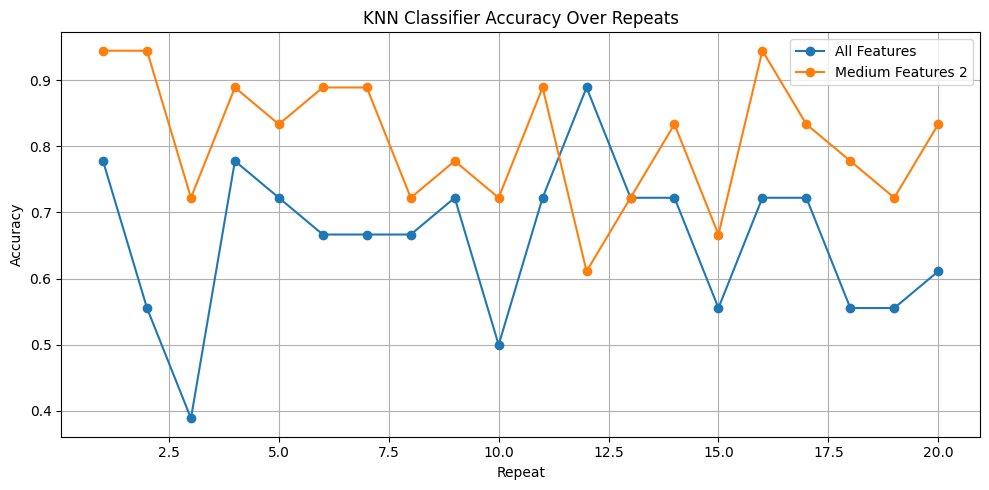

In [14]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2,  all_features, test_size=0.10, n_repeats=20)



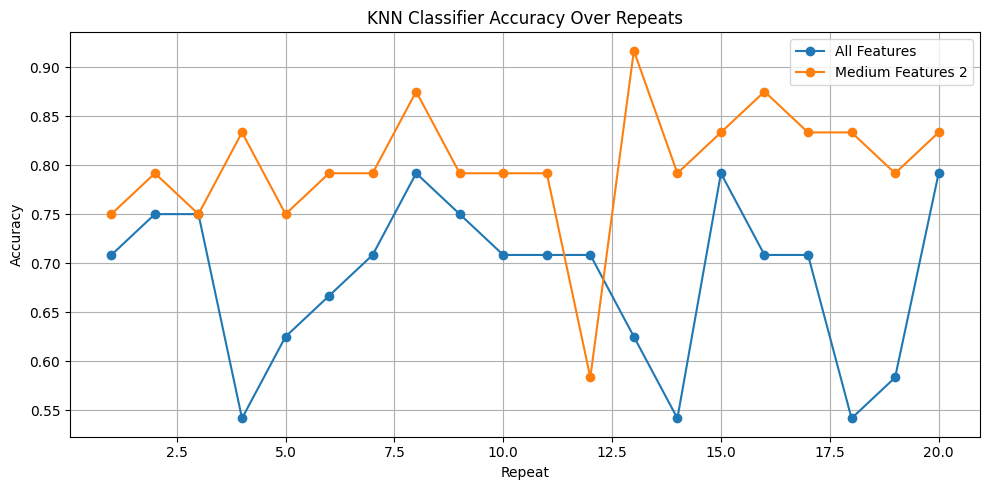

In [15]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2,  all_features, test_size=0.13, n_repeats=20)


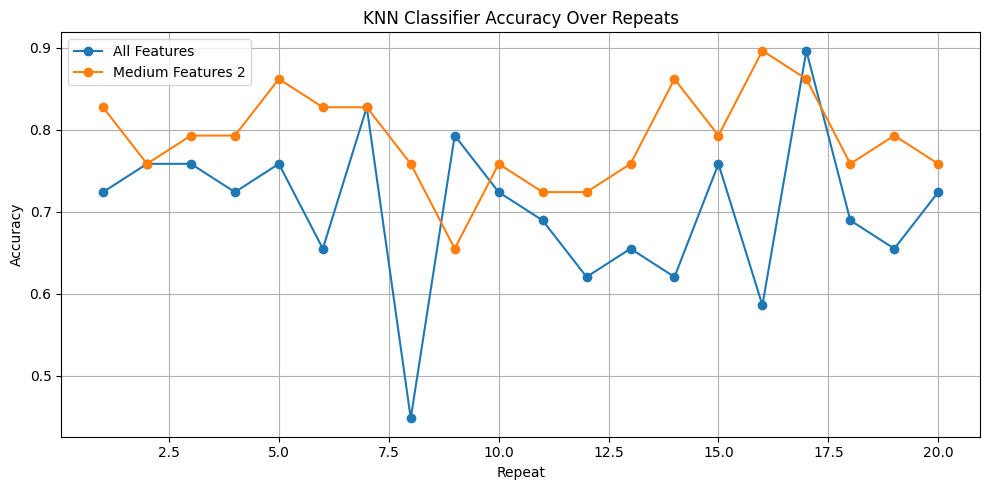

In [16]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2,  all_features, test_size=0.16, n_repeats=20)


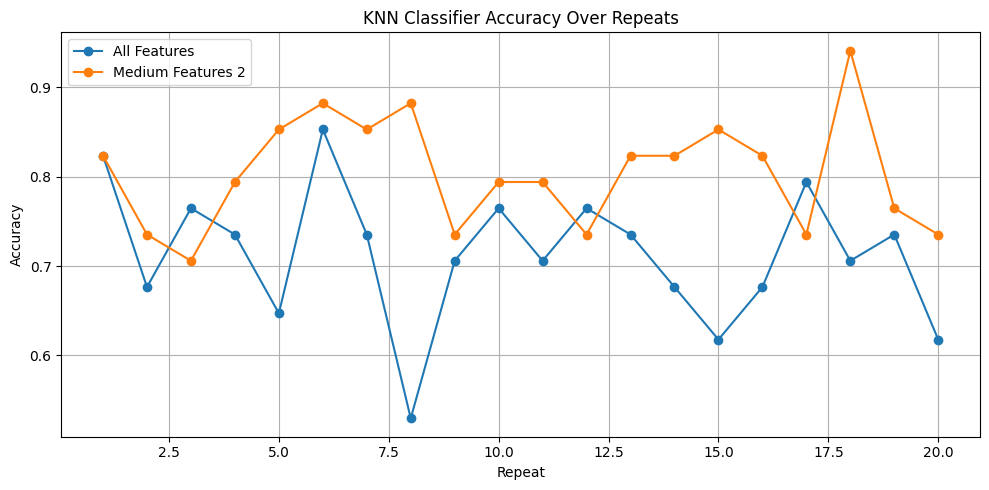

In [17]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2,  all_features, test_size=0.19, n_repeats=20)


🔎 Feature-wise Accuracy Ranking:
                         Feature  Accuracy
6                     flavanoids  0.842697
9                color_intensity  0.780899
11  od280/od315_of_diluted_wines  0.769663
12                       proline  0.764045
0                        alcohol  0.764045
10                           hue  0.747191
5                  total_phenols  0.724719
1                     malic_acid  0.713483
8                proanthocyanins  0.674157
4                      magnesium  0.640449
3              alcalinity_of_ash  0.589888
7           nonflavanoid_phenols  0.584270
2                            ash  0.578652

📊 Grouped Feature Performance Summary:
       Feature Group  Accuracy
0       All Features  0.786517
1    Strong Features       NaN
2  Medium (0.9-0.95)       NaN
3   Medium (0.8-0.9)  0.842697
4   Medium (0.7-0.8)  0.825843
5   Medium (0.6-0.7)  0.775281
6   Medium (0.5-0.6)  0.786517
7      Poor Features       NaN


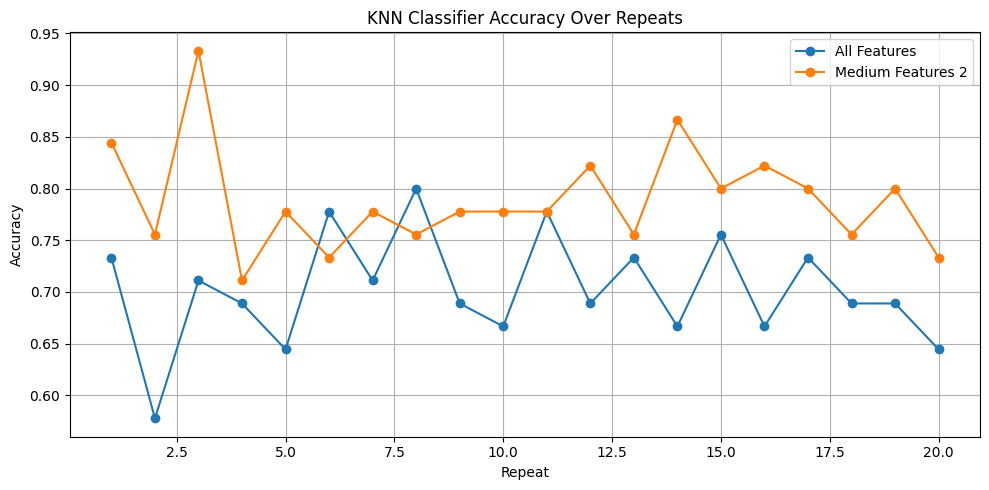

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)

# [3] Load Wine dataset
data = load_wine()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
all_features = data.feature_names

# [4] Prioritize all features by single-feature accuracy
feature_scores = prioritize_features_by_accuracy(X_data, y_data, all_features)
print("🔎 Feature-wise Accuracy Ranking:")
print(feature_scores)

# [5] Group features based on accuracy thresholds
strong_features = feature_scores[feature_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.9]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.8]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.7]['Feature'].tolist()
medium_features_4 = feature_scores[feature_scores['Accuracy'] > 0.6]['Feature'].tolist()
medium_features_5 = feature_scores[feature_scores['Accuracy'] > 0.5]['Feature'].tolist()
poor_features = feature_scores[feature_scores['Accuracy'] <= 0.5]['Feature'].tolist()

# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [all_features, strong_features, medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5, poor_features]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['All Features', 'Strong Features', 'Medium (0.9-0.95)', 'Medium (0.8-0.9)',
                      'Medium (0.7-0.8)', 'Medium (0.6-0.7)', 'Medium (0.5-0.6)', 'Poor Features'],
    'Accuracy': acc_scores
})

print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)

# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, medium_2,  all_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "medium_features_2": []

    }

    feature_groups = {
        "all_features": all_features,
        "medium_features_2": medium_2
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(10, 5))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2, all_features, test_size=0.25, n_repeats=20)


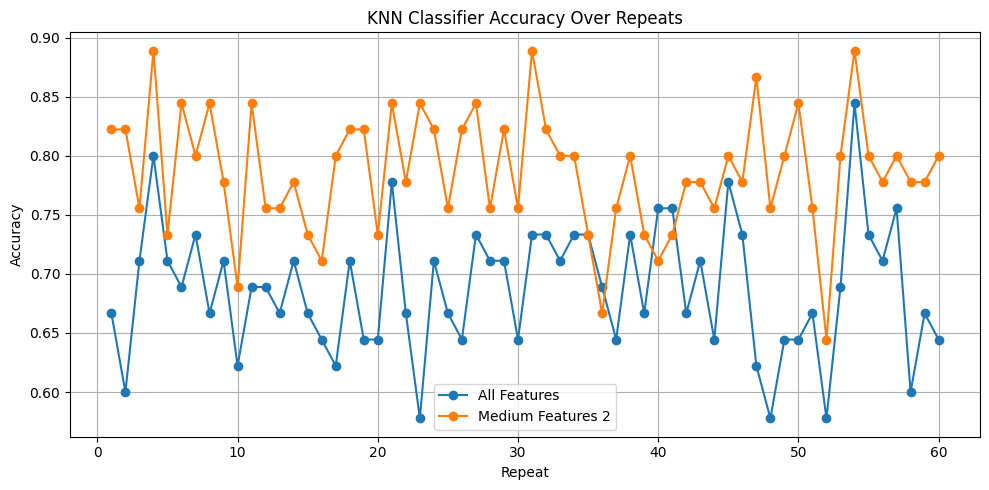

In [19]:
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2, all_features, test_size=0.25, n_repeats=60)


In [22]:
def build_accuracy_table(X_data, y_data, medium_2, all_features, test_sizes, n_repeats):
    results = []

    for test_size in test_sizes:
        for i in range(1, n_repeats + 1):
            X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

            # KNN for all features
            k_all = int(np.sqrt(len(X_train)))
            knn_all = KNeighborsClassifier(n_neighbors=k_all)
            knn_all.fit(X_train[all_features], y_train)
            y_pred_all = knn_all.predict(X_test[all_features])
            acc_all = accuracy_score(y_test, y_pred_all)

            # KNN for medium features
            k_modified = int(np.sqrt(len(X_train)))
            knn_modified  = KNeighborsClassifier(n_neighbors=k_modified )
            knn_modified .fit(X_train[medium_2], y_train)
            y_pred_modified  = knn_modified .predict(X_test[medium_2])
            acc_modified  = accuracy_score(y_test, y_pred_modified )

            results.append({
                "Percentage": f"{int(test_size * 100)}%",
                "Repetition": f"n={i}",
                "Accuracy (All Features)": acc_all,
                "Accuracy (Modified  KNN)": acc_modified
            })

    df_result = pd.DataFrame(results)
    return df_result


In [24]:
test_sizes = [0.10 , 0.13, 0.16 , 0.19 , 0.25]  # یا چند درصد دیگر مثل [0.10, 0.15, 0.25]
n_repeats = 20

accuracy_table = build_accuracy_table(X_data, y_data, medium_features_2, all_features, test_sizes, n_repeats)
print("\n📋 Accuracy Evaluation Table:")
print(accuracy_table)

# (اختیاری) ذخیره در فایل
# accuracy_table.to_csv("knn_accuracy_table.csv", index=False)



📋 Accuracy Evaluation Table:
   Percentage Repetition  Accuracy (All Features)  Accuracy (Modified  KNN)
0         10%        n=1                 0.777778                  0.833333
1         10%        n=2                 0.777778                  0.833333
2         10%        n=3                 0.722222                  0.777778
3         10%        n=4                 0.611111                  0.666667
4         10%        n=5                 0.611111                  0.722222
..        ...        ...                      ...                       ...
95        25%       n=16                 0.733333                  0.777778
96        25%       n=17                 0.711111                  0.711111
97        25%       n=18                 0.733333                  0.644444
98        25%       n=19                 0.622222                  0.777778
99        25%       n=20                 0.688889                  0.777778

[100 rows x 4 columns]
